# Quick start
*Last updated: Jan 20, 2020*

You have *whole genome* (WGS), *whole exome* (WES) or *targeted sequencing* (TGS) data from one or more tumour samples from the same patient and you wish to find clusters of mutations with similar *variant allele fractions* (VAF). You can use `clonosGP` to do that. The data can be either cross-sectional or longitudinal. In the case of longitudinal data, we can optionally exploit the temporal spacing of samples to improve clustering.

## 1. First, import the necessary packages

In [1]:
import logging as log
import warnings as warn
import pandas as pnd
import clonosGP as cln

log.getLogger('theano').setLevel(log.ERROR)             ## supress annoying warnings ...
warn.filterwarnings("ignore", category=FutureWarning)   ## from Theano

## 2. Next, load your data

In [2]:
DATA = pnd.read_csv('data/cll_Schuh_2012_CLL003.csv')
DATA

,SAMPLEID,TIME,MUTID,GENE,r,R
0,a,0,M1,ADAD1,22,38
1,a,0,M2,AMTN,9,33
2,a,0,M3,APBB2,19,43
3,a,0,M4,ASXL1,1,40
4,a,0,M5,ATM,31,37
...,...,...,...,...,...,...
135,e,35,M24,SEMA3E,36,58
136,e,35,M25,SF3B1,19,32
137,e,35,M26,SHROOM1,10,23
138,e,35,M27,SLC9A11,27,41


As you can see, the data are stored in long format. The minimum set of columns that must be present are `SAMPLEID`, `MUTID`, `r` and `R`, where `r` is the number of reads harbouring the mutation and `R` is the sum of `r` plus the number of reads harbouring the reference allele. In the case of longitudinal data (as above), column `TIME` may be present, indicating the relative time (in days or months) of sample collection. Each line should include information on a single mutation in a single sample. No missing values are permitted. Importantly, each mutation should be covered (i.e. `R>0`) in all samples, but not necessarily present in all samples, in which case `r=0`, as shown below:    

In [3]:
DATA.pivot_table(index='MUTID', columns=['SAMPLEID', 'TIME'], values=['r', 'R'])

R                   r                
SAMPLEID   a   b   c   d   e   a   b   c   d   e
TIME      0   19  25  31  35  0   19  25  31  35
MUTID                                           
M1        38  48  29  37  42  22  18  11  20  23
M10       39  34  41  50  35   0   0   6  19  12
M11       38  34  34  44  35  16  15   2   0   0
M12       46  33  44  49  32  16  13  17  34  15
M13       31  37  26  48  33  19  20   8  29  18
M14       42  45  46  22  25  15  18   2   1   0
M15       31  28  39  34  27  18  13  14  16  12
M16       46  37  35  42  28   2   0   6  19  13
M17       54  27  39  45  37  20  12   2   0   0
M18       46  30  34  47  33  25  13  14  25  20
M19       39  28  40  34  32   0   0  10  12  14
M2        33  30  40  46  25   9  16   3   0   0
M20       42  30  40  35  32   0   0  11  12  14
M21       42  34  33  53  32   0   0   6  27  19
M22       45  37  40  44  23  20  18   3   0   0
M23       43  33  28  38  29  21  17  15  16  13
M24       58  47  45  49  58   5   2   6  24  36
M25       44  33  35  44  32  22  21  10  18  19
M26       50  32  31  43  23  28  19   6  19  10
M27       36  43  42  64  41  20  25  16  32  27
M28       27  20  17  20  16   0   0   8  18  16
M3        43  38  35  40  44  19  17   2   0   0
M4        40  40  31  40  35   1   2  13  27  17
M5        37  19  25  26  19  31  16   1   0   0
M6        57  51  52  54  24  24  27   3   0   0
M7        26  32  40  47  33   0   0   9  20  14
M8        24  21  23  23  26   9   7   4  10   9
M9        40  32  35  47  27  17  14   3   0   0

The following columns should also be included, if available:
1. `PURITY`: the purity of each sample. If missing, it is assumed that `PURITY=1`. 
2. `CNn`: the local copy number at the locus of each mutation in the germline. If missing, it is assumed that `CNn=2`.
3. `CNt`: the local copy number at the locus of each mutation in each sample. If missing, it is assumed that `CNt=2`.
4. `CNm`: the number of chromosomes harbouring each mutation in each sample. If missing, it will be estimated from the data. 

Any additional columns are ignored.

## 3. Run `clonosGP`

In [4]:
RES = cln.infer(DATA, 
                model_args={'prior': 'GP0', 'cov': 'Mat32'},    ## change "GP0" to "Flat", for cross-sectional data
                pymc3_args={'niters': int(10e3)})               ## Run inference for 10K iterations 

## the above may take some time to start running the first time you try it.  

INFO:clonosGP:No PURITY column in the data. Assuming all samples have purity 100%.
INFO:clonosGP:No CNn column in the data. Assuming germline is diploid over all provided loci.
INFO:clonosGP:No CNt column in the data. Assuming all tumour samples are diploid over all provided loci.
INFO:clonosGP:No CNm column in the data. Multiplicity values will be approximated.
Average Loss = 377.69: 100%|██████████| 10000/10000 [00:13<00:00, 738.95it/s]
Finished [100%]: Average Loss = 377.68
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 377.68
INFO:clonosGP:Calculating posterior cluster weights and centres.
INFO:clonosGP:Calculating posterior CCF values.
INFO:clonosGP:Calculating posterior predictive distribution.
INFO:clonosGP:Calculating GP-related quantities.
INFO:clonosGP:Calculating dispersion(s).
INFO:clonosGP:Finished.


## 4. Visualise the results

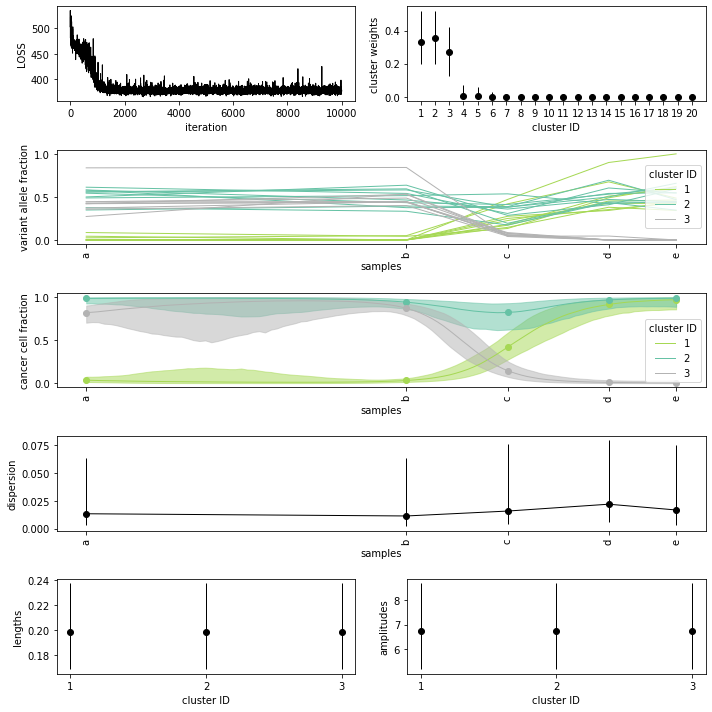

In [5]:
cln.viz.plot_summary(RES, figsize=(10, 10));

Make sure that the algorithm has converged by inspecting the loss (top-left panel). If not, rerun with a larger number of iterations. Cluster weights (i.e. proportions of mutations belonging to each cluster) are illustrated at the top-right panel. A color-encoded hard clustering of mutations and the time course of each mutation cluster are provided in the two middle panels. Finally, estimated sample-specific dispersions, time scales (lengths) and amplitudes of the underlying Gaussian Process for modelling cluster dynamics are provided at the bottom three panels, respectively. For an overview of the fitted model, check below:

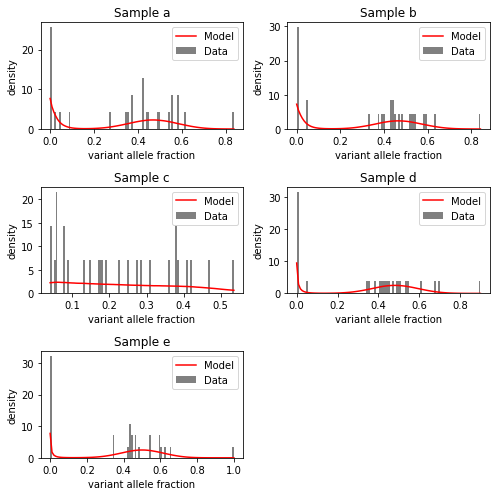

In [6]:
cln.viz.plot_samples(RES, figsize=(7, 7));

## 5. Inspect the results in more detail

In [7]:
RES['data']

,SAMPLEID,PURITY,TIME,TIME2,MUTID,r,R,CNn,CNt,CNm,VAF,VAF0,CCF_,CCF,CCF_HI,CCF_LO,PPD,PPD_HI,PPD_LO,CLUSTERID
0,a,1.0,0,0.0,M1,22.0,38.0,2.0,2.0,1.0,0.578947,0.5,1.000000,0.982911,0.996753,0.924945,1.211057,1.697353,0.728661,2
1,a,1.0,0,0.0,M10,0.0,39.0,2.0,2.0,1.0,0.000000,0.5,0.000000,0.034568,0.074447,0.013574,7.684848,14.193807,3.365228,1
2,a,1.0,0,0.0,M11,16.0,38.0,2.0,2.0,1.0,0.421053,0.5,0.842105,0.818082,0.901679,0.701902,2.173728,2.867668,1.395301,3
3,a,1.0,0,0.0,M12,16.0,46.0,2.0,2.0,1.0,0.347826,0.5,0.695652,0.982687,0.996645,0.896454,1.473441,2.148376,0.933903,2
4,a,1.0,0,0.0,M13,19.0,31.0,2.0,2.0,1.0,0.612903,0.5,1.000000,0.982880,0.996713,0.922595,0.875358,1.236831,0.506098,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,e,1.0,35,1.0,M5,0.0,19.0,2.0,2.0,1.0,0.000000,0.5,0.000000,0.004621,0.033443,0.000455,4.860567,7.817806,2.413525,3
136,e,1.0,35,1.0,M6,0.0,24.0,2.0,2.0,1.0,0.000000,0.5,0.000000,0.004621,0.033443,0.000455,6.045319,9.836331,2.968965,3
137,e,1.0,35,1.0,M7,14.0,33.0,2.0,2.0,1.0,0.424242,0.5,0.848485,0.968856,0.995226,0.856757,2.202870,2.853950,1.517548,1
138,e,1.0,35,1.0,M8,9.0,26.0,2.0,2.0,1.0,0.346154,0.5,0.692308,0.982897,0.998531,0.736782,1.249482,1.718249,0.928394,2


`clonosGP` returns the original data matrix with additional columns attached. 
1. `CLUSTERID` returns the most likely cluster assigment. Mutations with the same `CLUSTERID` were assigned to the same cluster.
2. Columns `CCF`, `CCF_HI` and `CCF_LO` are the estimated median *cancer cell fraction* (CCF) along with 95% *credible intervals*. Notice that if `PURITY` is not provided by the user, it is assumed to be 100%. In this case, CCF should be interpreted as the *cellular prevalence* of the mutation (i.e. the fraction of both normal and cancer cells harbouring the mutation), not as the cancer cell fraction. `CCF_` is a first, rough estimate of CCF.
3. `PPD`, `PPD_HI`, `PPD_LO` are the median *posterior predictive distribution* and 95% credible intervals, resepctively.
4. `VAF` is the *variant allele fraction* of the mutation, calculated as `r/R`; `VAF0` would be the expected VAF if the mutation was clonal (i.e. if the mutation had CCF=1).
5. `TIME2` is `TIME` scaled to fit in the interval [0, 1].
6. `PURITY`, `CNn`, `CNt` and `CNm` are the quantities we used internally, in case they were not provided by the user.

**This is the end of this quick introduction to `clonosGP`**